## Computer Vision and Cognitive Systems Group Project
### Virtual Try-On Complete Pipeline Execution
Group #13: Francesco Sala, Francesco Martucci, Felicia Puzone \
2022/2023

This demo aims to show the execution flow of the project pipeline. We start from some input images and progress step-by-step to the output image.


> Let us have a person image and a cloth image. The main goal is to replace the upper body cloth with the selected in-shop garment.



> First of all, let us import the git application repository and the python packages.



In [1]:
!git clone https://github.com/felicia-puzone/virtual-try-on-app.git

Cloning into 'virtual-try-on-app'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (749/749), done.
remote: Compressing objects: 100% (607/607), done.
remote: Total 749 (delta 139), reused 730 (delta 123), pack-reused 0
Receiving objects: 100% (749/749), 4.24 MiB | 16.08 MiB/s, done.
Resolving deltas: 100% (139/139), done.


In [2]:
from PIL import Image, ImageOps, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json

For visualization:

In [3]:
def plot_img_list(img_list):
    k = len(img_list)
    figure, ax = plt.subplots(nrows=1, ncols=k, figsize=(6, 6))

    for index in range(k):
        ax[index].imshow(img_list[index])

    figure.tight_layout()
    figure.show()
    plt.show()

> From the folder _input-images_, we first try the app on some images taken from the dataset DressCode, on which the application was trained.



In [4]:

%cd virtual-try-on-app/

/content/virtual-try-on-app


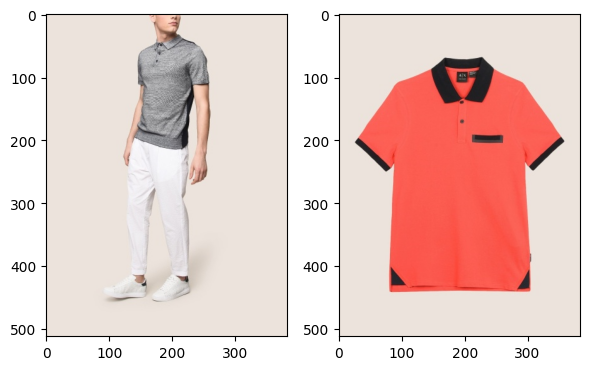

In [5]:

person_image = cv2.imread(r"input_images/people/000179_0.jpg")
cloth_image = cv2.imread(r"input_images/garments/000136_1.jpg")

cv2.imwrite('./result/images/000179_0.jpg', person_image)
cv2.imwrite('./result/cloth/000136_1.jpg', cloth_image)


person_image = cv2.cvtColor(person_image, cv2.COLOR_BGR2RGB)
cloth_image = cv2.cvtColor(cloth_image, cv2.COLOR_BGR2RGB)

show_list = [person_image, cloth_image]

plot_img_list(show_list)



> We apply some contrast adjusting and a bilateral filter to smooth the images.
 ### Contrast stretching
 $I_o = (I_i - min_i)*((max_o - min_o)/(max_i - min_i)) + min_o$

**Contrast stretching** is a simple image enhancement technique that attempts to improve the contrast in an image by `stretching' the range of intensity values it contains to span a desired range of values

A **bilateral filter** is a non-linear, edge-preserving, and noise-reducing smoothing filter for images. We believed this filter could enhance image quality and make them more like the training image examples.


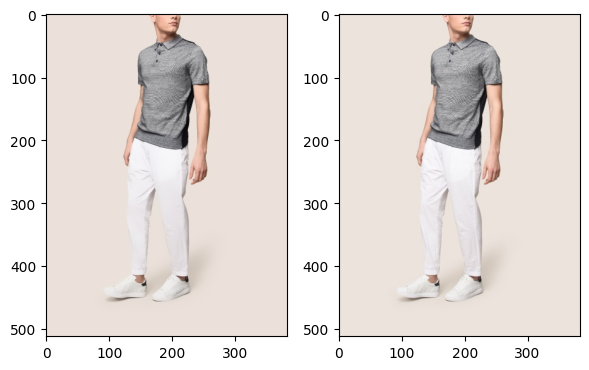

In [6]:
def ContrastStretching(img, min_o = 0, max_o = 255):

  out = (img - img.min())*((max_o - min_o)/(img.max() - img.min())) + min_o
  return out.astype(img.dtype)

person_image_proc = ContrastStretching(person_image)

person_image_proc = cv2.bilateralFilter(person_image_proc, 20, 15, 15)

show_list = [person_image_proc, person_image]


plot_img_list(show_list)


## SCHP

Downloading atr SCHP checkpoints

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [8]:
!pip install ninja

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.0/146.0 kB 3.2 MB/s eta 0:00:00


In [9]:
os.getcwd()

'/content/virtual-try-on-app'

In [10]:
%cd people-preprocessing/

!python simple_extractor.py --dataset 'atr' --input-dir ./../input_images/people --output-dir ./../result/label_maps --model-restore ./../../gdrive/MyDrive/exp-schp-201908301523-atr.pth



/content/virtual-try-on-app/people-preprocessing
Evaluating total class number 18 with ['Background', 'Hat', 'Hair', 'Sunglasses', 'Upper-clothes', 'Skirt', 'Pants', 'Dress', 'Belt', 'Left-shoe', 'Right-shoe', 'Face', 'Left-leg', 'Right-leg', 'Left-arm', 'Right-arm', 'Bag', 'Scarf']
100% 2/2 [00:07<00:00,  3.79s/it]


/content/virtual-try-on-app


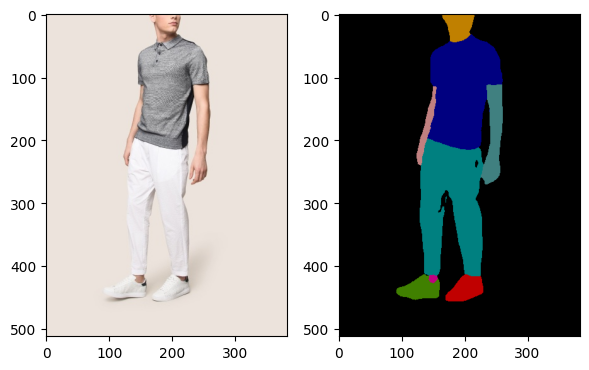

In [11]:
%cd ..
labels_image = cv2.imread(r"./result/label_maps/000179_4.png")
labels_image = cv2.cvtColor(labels_image, cv2.COLOR_BGR2RGB)

show_list = [person_image, labels_image]

plot_img_list(show_list)

## Mask Image Generation
Now that we have the label map, we can use a simple function to generate the people mask, needed as input for the geometric and generative modules.

In [12]:
os.getcwd()

'/content/virtual-try-on-app'

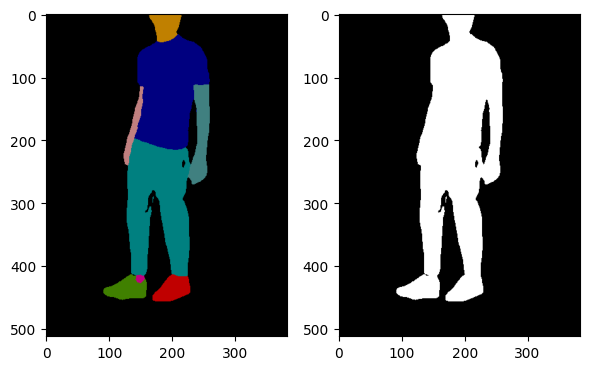

In [13]:
def get_mask_from_labels(img):

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img[img != 0] = 255
    return img

mask_image = get_mask_from_labels(labels_image)

cv2.imwrite('./result/image-mask/000179_0.png', mask_image)

show_list = [labels_image, cv2.cvtColor(mask_image, cv2.COLOR_GRAY2RGB)]

plot_img_list(show_list)


## KEYPOINT EXTRACTION with Detectron2
Due to problems with openpose build (servers are off and the build failed because it could not download the coffeemodels), we adopted another strategy. We use Detectron2 keypoint extractor and then convert the keypoints order and we interpolate a missing keypoint.


In [14]:
%cd ..

/content


In [15]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 5.6 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15253, done.
remote: Counting objects: 100% (274/274), done.
remote: Compressing objects: 100% (169/169), done.
remote: Total 15253 (delta 143), reused 181 (delta 105), pack-reused 14979
Receiving objects: 100% (15253/15253), 6.28 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (11010/11010), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 1.6 MB/s eta 0:00

In [16]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [17]:
os.getcwd()

'/content'

In [18]:
%cd virtual-try-on-app/detectron2_scripts/
import d2

/content/virtual-try-on-app/detectron2_scripts


Getting the correct keypoints format ( [18,3] )

In [19]:
openpose_keypoints = d2.get_keypoints(person_image)
openpose_keypoints.shape
#print(openpose_keypoints)

model_final_a6e10b.pkl: 237MB [00:01, 149MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([18, 3])

Now we put these keypoints into a formatted json.

In [20]:
%cd ..

/content/virtual-try-on-app


In [21]:
def json_parser(tensor_keypoints):

    parsed_list = []

    data = {}
    data['version'] = 1.0,
    data['people'] = {}
    data['people']['face_keypoints'] = []
    data['people']['pose_keypoints'] = []
    data['people']['hand_right_keypoints'] = []
    data['people']['hand_left_keypoints'] = []


    keypoints = tensor_keypoints.tolist()

    for keypoint in keypoints:

        if -1.0 not in keypoint[:3]: data['people']['pose_keypoints'].extend(keypoint[:3])
        else: data['people']['pose_keypoints'].extend([0,0,0])

        parsed_list.append(json.dumps(data))

    return json.dumps(data)

with open("./result/keypoints-openpose/000179_2.json", "w") as outfile:
    outfile.write(json_parser(openpose_keypoints))

We can also visualize the result with a drawing method.

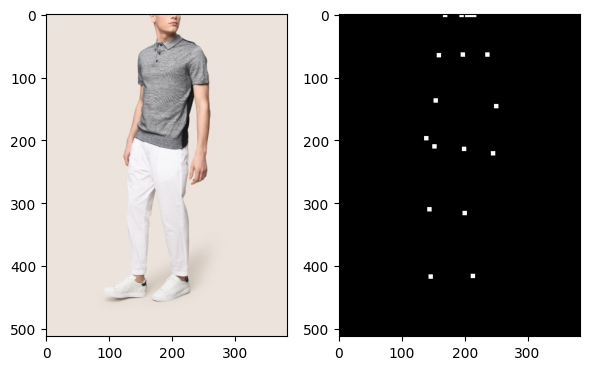

In [22]:
def draw_keypoints(tensor_keypoints, height, width, radius):
  point_num = tensor_keypoints.shape[0]
  r = radius
  im_pose = Image.new('L', (width, height))
  pose_draw = ImageDraw.Draw(im_pose)

  for i in range(point_num):

    pose_draw = ImageDraw.Draw(im_pose)
    pointx = tensor_keypoints[i, 0]
    pointy = tensor_keypoints[i, 1]
    if pointx > 1 and pointy > 1:
      pose_draw.rectangle((pointx-r, pointy-r, pointx+r, pointy+r), 'white', 'white')

  return im_pose


im_pose = draw_keypoints(openpose_keypoints, 512, 384, 3)

show_list = [person_image, cv2.cvtColor(np.array(im_pose), cv2.COLOR_GRAY2RGB)]

plot_img_list(show_list)

So the person input is now ready. Next step is the cloth input set up.

## Cloth mask generation

Other than the garment image, the network needs the cloth image mask. For this task, we created a method that detects contours with Canny algorithm and fills the contours to generate a mask. We also used this function to generate masks for training. It can sometimes fail in connecting the contours properly, but in the majority of cases it works.

In [23]:
def generateMask(img, sharpenLevel = 0):

    #ADJUSTING BRIGHTNESS/CONTRAST

    # define the contrast and brightness value
    contrast = 1.05    # Contrast control ( 0 to 127)
    brightness = 0.05  # Brightness control (0-100)

    # call addWeighted function. use beta = 0 to effectively only

    adjusted = cv2.addWeighted(img, contrast, img, 0, brightness)

    #Sharpening kernel 1
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

    if(sharpenLevel == 1):
        adjusted = cv2.filter2D(adjusted, -1, kernel)

    v = np.median(adjusted)
    sigma = 0.99

    lower_thresh = int(max(0, (1.0 - sigma) * v))
    upper_thresh = int(min(255, (1.0 + sigma) * v))

    edges = cv2.Canny(adjusted, 0, 255)

    edges = cv2.dilate(edges, np.ones((5, 5), np.uint8))

    contours, hierarchy = cv2.findContours(edges,
                                           cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    # Canny Edges After Contouring

    print("Number of Contours found = " + str(len(contours)))

    # Draw all contours
    # -1 signifies drawing all contours
    mask = np.zeros(img.shape, dtype=np.uint8)

    cv2.drawContours(mask, contours, 0, color=(255, 255, 255), thickness=cv2.FILLED)

    if (sharpenLevel == 1):
        mask = cv2.medianBlur(mask, 33)

    #computing White/Black Ratio

    mask_white_count = (mask==255).sum()
    mask_black_count = (mask==0).sum()

    wb_ratio = mask_white_count/mask_black_count

    return mask

In [24]:
os.getcwd()

'/content/virtual-try-on-app'

Number of Contours found = 1


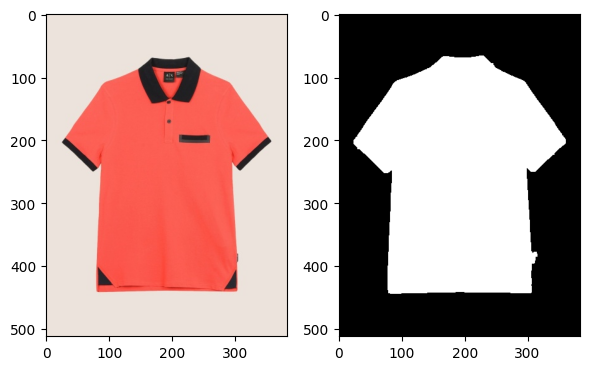

True

In [25]:
cloth_mask = generateMask(np.array(cloth_image), sharpenLevel = 0)

show_list = [cloth_image, cloth_mask]

plot_img_list(show_list)
cv2.imwrite('./result/cloth-mask/000136_1.png', cloth_mask)

# GMM Inference

In [26]:
%cd network

/content/virtual-try-on-app/network


In [27]:
!pip install einops tensorboardX

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 4.2 MB/s eta 0:00:00


In [33]:
import subprocess
import shutil
import time

t = time.time()
!python test.py --name GMM --stage GMM --workers 4 --dataroot ./../result --datamode test --data_list ./../result/inference.txt --checkpoint ./../../gdrive/MyDrive/step_115000_final2.pth

Namespace(name='GMM', dress_type='upper', gpu_ids='', workers=4, batch_size=4, dataroot='./../result', datamode='test', stage='GMM', data_list='./../result/inference.txt', fine_width=384, fine_height=512, radius=5, grid_size=10, tensorboard_dir='tensorboard', result_dir='result', checkpoint='./../../gdrive/MyDrive/step_115000_final2.pth', display_count=1, shuffle=False)
Start to test stage: GMM, named: GMM!
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
initialization method [normal]
initialization method [normal]
step:        1, time: 0.873
Finished test GMM, named

Showing the warping result:

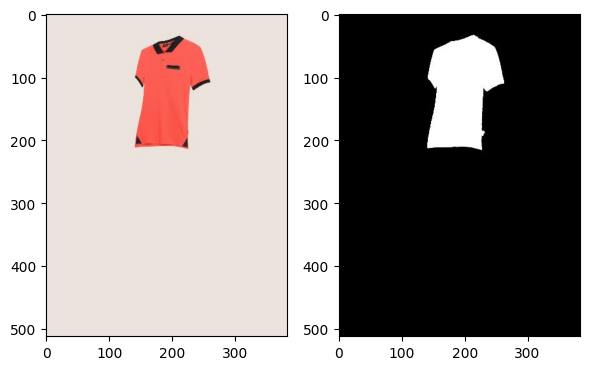

In [35]:
warped_cloth = Image.open(r"result/GMM/test/warp-cloth/000179_0.jpg")
warped_mask = cv2.imread(r"result/GMM/test/warp-mask/000179_0.jpg")

cv2.cvtColor(np.array(warped_cloth), cv2.COLOR_BGR2RGB)

show_list3 = [warped_cloth, warped_mask]

plot_img_list(show_list3)

Try-On Module INFERENCE

In [36]:
warp_cloth = "result/GMM/test/warp-cloth"
warp_mask = "result/GMM/test/warp-mask"

shutil.copytree(warp_cloth, "../result/warp-cloth", dirs_exist_ok=True)
shutil.copytree(warp_mask, "../result/warp-mask", dirs_exist_ok=True)

'../result/warp-mask'

# Try-on Module

In [37]:
os.getcwd()

'/content/virtual-try-on-app/network'

In [38]:
!python test.py --name TOM --stage TOM --workers 4 --datamode test --dataroot ./../result --data_list ./../result/inference.txt --checkpoint ./../../gdrive/MyDrive/CIT_final.pth

Namespace(name='TOM', dress_type='upper', gpu_ids='', workers=4, batch_size=4, dataroot='./../result', datamode='test', stage='TOM', data_list='./../result/inference.txt', fine_width=384, fine_height=512, radius=5, grid_size=10, tensorboard_dir='tensorboard', result_dir='result', checkpoint='./../../gdrive/MyDrive/CIT_final.pth', display_count=1, shuffle=False)
Start to test stage: TOM, named: TOM!
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Dataset size: 00001!
step:        1, time: 1.988
Finished test TOM, named: TOM!


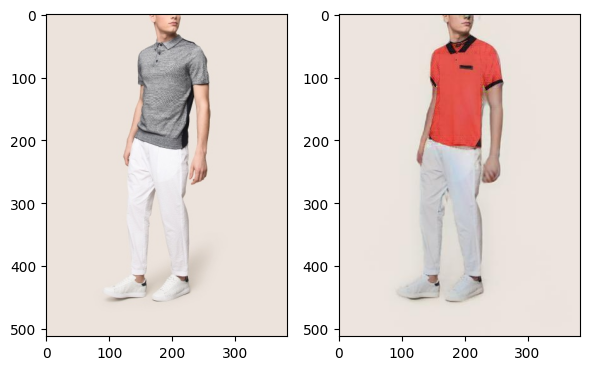

In [42]:
tryon = cv2.imread(r"./result/TOM/test/try-on/000179_0.jpg")

try_on_path = "./result/TOM/test/try-on"

shutil.copytree(try_on_path, "./../result/tryon/ours", dirs_exist_ok=True)

tryon = cv2.cvtColor(tryon, cv2.COLOR_BGR2RGB)

show_list = [person_image, tryon]

plot_img_list(show_list)

# SUPER-RESOLUTION  with StableDiffusion

In [44]:
%cd ..
%cd super-resolution
#!pip install diffusers accelerate transformers

/content/virtual-try-on-app
/content/virtual-try-on-app/super-resolution


In [45]:
os.makedirs("./../result/super-resolution-output", exist_ok=True)

In [47]:
from diffusers import ControlNetModel, DiffusionPipeline
from diffusers.utils import load_image
from diffusers.pipelines.stable_diffusion.safety_checker import StableDiffusionSafetyChecker

def resize_for_condition_image(input_image: Image, resolution: int):
    input_image = input_image.convert("RGB")
    W, H = input_image.size
    k = float(resolution) / min(H, W)
    H *= k
    W *= k
    H = int(round(H / 64.0)) * 64
    W = int(round(W / 64.0)) * 64
    img = input_image.resize((W, H), resample=Image.LANCZOS)
    return img

controlnet = ControlNetModel.from_pretrained('lllyasviel/control_v11f1e_sd15_tile',
                                             torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5",
                                         custom_pipeline="stable_diffusion_controlnet_img2img",
                                         controlnet=controlnet,
                                         torch_dtype=torch.float16).to('cuda')
#pipe.enable_xformers_memory_efficient_attention()

source_image = load_image('./../result/tryon/ours/000179_0.jpg')

condition_image = resize_for_condition_image(source_image, 1024)
image = pipe(prompt="best quality, clothes, garment, model, shop, upper clothes",
             negative_prompt="blur, lowres, bad anatomy, bad clothes, bad hands, cropped, worst quality, fading, glitch, robot, tech, high saturation, medieval",
             image=condition_image,
             controlnet_conditioning_image=condition_image,
             width=condition_image.size[0],
             height=condition_image.size[1],
             strength=1.0,
             generator=torch.manual_seed(0),
             num_inference_steps=14,
            ).images[0]

image.save('./../result/super-resolution-output/000179.jpg')


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/14 [00:00<?, ?it/s]

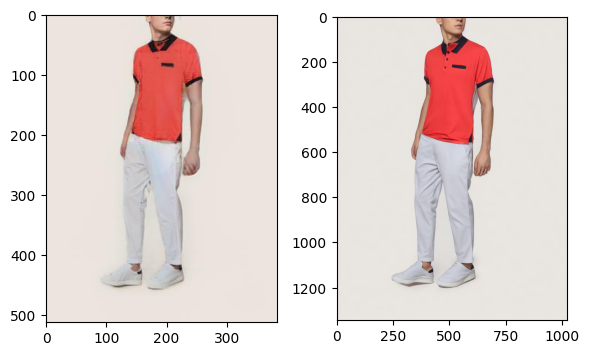

In [48]:
super_resolution = Image.open('./../result/super-resolution-output/000179.jpg')

show_list = [tryon, super_resolution]

plot_img_list(show_list)